<a href="https://colab.research.google.com/github/brunokobi/Reconhecimento_Padrao/blob/main/C%C3%B3pia_de_titanicBruno.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
data = pd.read_csv("/train.csv")
data.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

**Matriz de Correlação**

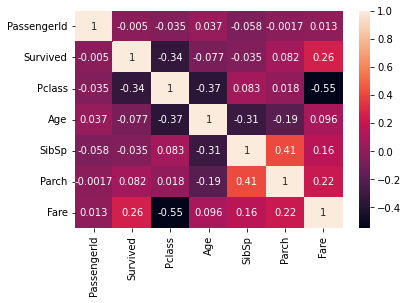

In [ ]:
import seaborn as sns 
ax = sns.heatmap(data.corr(), annot=True) 

In [ ]:
y = data['Survived']
y

0      0
1      1
2      1
3      1
4      0
      ..
886    0
887    1
888    0
889    1
890    0
Name: Survived, Length: 891, dtype: int64

In [ ]:
X = data.drop('Survived', axis=1)
X.columns

Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [ ]:
for column in X.columns:
  print(f"{column:>12} {len(set(X[column])):4} {X[column].dtype}")

 PassengerId  891 int64
      Pclass    3 int64
        Name  891 object
         Sex    2 object
         Age  265 float64
       SibSp    7 int64
       Parch    7 int64
      Ticket  681 object
        Fare  248 float64
       Cabin  148 object
    Embarked    4 object


In [ ]:
indesejadas = ['PassengerId', 'Name', 'Ticket', 'Cabin']
Xdrop = X.drop(indesejadas, axis=1)
Xdrop.columns

Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked'], dtype='object')

In [ ]:
Xnum = Xdrop.select_dtypes('number')
Xnum.columns

Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare'], dtype='object')

In [ ]:
for column in Xnum.columns:
  print(f"{column:>12} {sum(Xnum[column].isnull())}")

      Pclass 0
         Age 177
       SibSp 0
       Parch 0
        Fare 0


In [ ]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')
XnumLimpo = imputer.fit_transform(Xnum)
XnumLimpo

array([[ 3.    , 22.    ,  1.    ,  0.    ,  7.25  ],
       [ 1.    , 38.    ,  1.    ,  0.    , 71.2833],
       [ 3.    , 26.    ,  0.    ,  0.    ,  7.925 ],
       ...,
       [ 3.    , 28.    ,  1.    ,  2.    , 23.45  ],
       [ 1.    , 26.    ,  0.    ,  0.    , 30.    ],
       [ 3.    , 32.    ,  0.    ,  0.    ,  7.75  ]])

In [ ]:
Xcat = Xdrop.select_dtypes('object')
Xcat.columns

Index(['Sex', 'Embarked'], dtype='object')

In [ ]:
for column in Xcat.columns:
  print(f"{column:>12} {sum(Xcat[column].isnull())}")

         Sex 0
    Embarked 2


In [ ]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='most_frequent')
XcatLimpo = imputer.fit_transform(Xcat)
XcatLimpo

array([['male', 'S'],
       ['female', 'C'],
       ['female', 'S'],
       ...,
       ['female', 'S'],
       ['male', 'C'],
       ['male', 'Q']], dtype=object)

In [ ]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
XcatHot = encoder.fit_transform(XcatLimpo)
XcatHot

<891x5 sparse matrix of type '<class 'numpy.float64'>'
	with 1782 stored elements in Compressed Sparse Row format>

In [ ]:
import numpy as np
Xtratado = np.c_[XnumLimpo, XcatHot.toarray()]
Xtratado.shape

(891, 10)

In [ ]:
import pandas as pd
train = pd.read_csv('/train.csv')
test = pd.read_csv('/test.csv')
train.columns.isin(test.columns)

array([ True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

In [ ]:
# Salvar PassengerId para auxiliar na criação do arquivo que será enviado ao Kaggle
passengerId = test['PassengerId']
passengerId


0       892
1       893
2       894
3       895
4       896
       ... 
413    1305
414    1306
415    1307
416    1308
417    1309
Name: PassengerId, Length: 418, dtype: int64

In [ ]:
train.columns[~train.columns.isin(test.columns)]

Index(['Survived'], dtype='object')

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

class AtributosDesejados(BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
    self.colunasIndesejadas = ['PassengerId', 'Name', 'Ticket', 'Cabin']
    return self
  def transform(self, X, y=None):
    return X.drop(indesejadas, axis=1)
  
atributosDesejados = AtributosDesejados()
Xdrop = atributosDesejados.fit_transform(X)
Xdrop.columns

Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked'], dtype='object')

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

class AtributosNumericos(BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
    self.colunasNumericas = X.select_dtypes(include='number').columns
    return self
  def transform(self, X, y=None):
    return X[self.colunasNumericas]
  
atributosNumericos = AtributosNumericos()
Xnum = atributosNumericos.fit_transform(Xdrop)
Xnum.columns

Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare'], dtype='object')

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

pipenum = Pipeline([
    ('atributos_numericos', AtributosNumericos()),
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

XnumLimpo = pipenum.fit_transform(Xdrop)
XnumLimpo

array([[ 0.82737724, -0.56573646,  0.43279337, -0.47367361, -0.50244517],
       [-1.56610693,  0.66386103,  0.43279337, -0.47367361,  0.78684529],
       [ 0.82737724, -0.25833709, -0.4745452 , -0.47367361, -0.48885426],
       ...,
       [ 0.82737724, -0.1046374 ,  0.43279337,  2.00893337, -0.17626324],
       [-1.56610693, -0.25833709, -0.4745452 , -0.47367361, -0.04438104],
       [ 0.82737724,  0.20276197, -0.4745452 , -0.47367361, -0.49237783]])

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

class AtributosCategoricos(BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
    self.colunasCategoricas = X.select_dtypes(include='object').columns
    return self
  def transform(self, X, y=None):
    return X[self.colunasCategoricas]

atributosCategoricos = AtributosCategoricos()
Xcat = atributosCategoricos.fit_transform(Xdrop)
Xcat.columns

Index(['Sex', 'Embarked'], dtype='object')

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

pipecat = Pipeline([
    ('atributos_categoricos', AtributosCategoricos()),
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder())
])

XcatLimpo = pipecat.fit_transform(Xdrop)
XcatLimpo

<891x5 sparse matrix of type '<class 'numpy.float64'>'
	with 1782 stored elements in Compressed Sparse Row format>

In [ ]:
from sklearn.pipeline import FeatureUnion

unecaracteristicas = FeatureUnion([
    ('pipenum', pipenum),
    ('pipecat', pipecat)
])

Xtratado = unecaracteristicas.fit_transform(Xdrop)
Xtratado

<891x10 sparse matrix of type '<class 'numpy.float64'>'
	with 6237 stored elements in Compressed Sparse Row format>

In [ ]:
from sklearn.pipeline import Pipeline

preproc = Pipeline([
    ('atributos_desejados', AtributosDesejados()),
    ('unecaracteristicas', unecaracteristicas)
])

Xtratado = preproc.fit_transform(X)
Xtratado

<891x10 sparse matrix of type '<class 'numpy.float64'>'
	with 6237 stored elements in Compressed Sparse Row format>

**Teste Arvore de Decisão**

In [ ]:
from sklearn.tree import DecisionTreeClassifier

pipetotal = Pipeline([
    ('preproc', preproc),
    ('arvore', DecisionTreeClassifier(splitter='random'))
])

**Teste Random Forest**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
pipetotal = Pipeline([
    ('preproc', preproc),
    ('forest', RandomForestClassifier(criterion='gini',
                                      n_estimators=1750,
                                      max_depth=7,
                                      min_samples_split=6,
                                      min_samples_leaf=6,
                                      max_features='auto',
                                      oob_score=True,
                                      random_state=42,
                                      n_jobs=1,
                                      verbose=1))
])

**Teste KNN**

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
pipetotal = Pipeline([
    ('preproc', preproc),
    ('KNN',   KNeighborsClassifier(3))
  ])

**Teste Rede Neural**

In [ ]:
from sklearn.neural_network import MLPClassifier
pipetotal = Pipeline([
    ('preproc', preproc),
    # ajuste classificador
    ('neural',  MLPClassifier(solver='adam',max_iter=2000, hidden_layer_sizes=5, random_state=1, tol=0.0000001))
    # ('neural',  MLPClassifier(alpha=1, max_iter=550))
  ])

**Teste AdaBoost**

In [ ]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
pipetotal = Pipeline([
    ('preproc', preproc),
    ('adaboost', AdaBoostClassifier())
  ])

**Teste Bagging**

In [ ]:
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
pipetotal = Pipeline([
    ('preproc', preproc),
    ('bagging',BaggingClassifier(random_state=42))
  ])

**Métrica modelo**

In [ ]:
from sklearn.metrics import accuracy_score

pipetotal.fit(X, y)
ypred = pipetotal.predict(X)
accuracy_score(y, ypred)

0.8473625140291807

In [ ]:
import numpy as np
from sklearn.model_selection import cross_validate

scores = cross_validate(pipetotal, X, y)
scores, np.mean(scores['test_score'])

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


({'fit_time': array([3.51835203, 5.58614969, 2.56779647, 3.96941423, 3.01658773]),
  'score_time': array([0.00788498, 0.00831199, 0.00719643, 0.01001239, 0.00745559]),
  'test_score': array([0.81005587, 0.80898876, 0.83707865, 0.79213483, 0.85955056])},
 0.8215617349821104)

In [ ]:
pipetotal.fit(X, y)
ypred = pipetotal.predict(test)
ypred


array([0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

**Gerar CSV**

In [ ]:
import pandas as pd
df = pd.DataFrame({'PassengerId':passengerId,'Survived':ypred})
df.to_csv("/bruno7.csv",index=False)

In [ ]:
from sklearn.model_selection import GridSearchCV

parametros = {
    'arvore__max_depth': [None] + list(range(1,10,2)),
    'preproc__unecaracteristicas__pipenum__imputer__strategy': ['mean', 'median', 'most_frequent']
}

modelo = GridSearchCV(pipetotal, param_grid=parametros)

scores = cross_validate(modelo, X, y)
scores, np.mean(scores['test_score'])

In [ ]:
from sklearn.model_selection import GridSearchCV

parametros = {  
    'neural__max_iter': [None] + list(range(1,10,2)),
    'preproc__unecaracteristicas__pipenum__imputer__strategy': ['mean', 'median', 'most_frequent']
}

modelo = GridSearchCV(pipetotal, param_grid=parametros)

scores = cross_validate(modelo, X, y)
scores, np.mean(scores['test_score'])

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_pe

({'fit_time': array([5.76084518, 5.78288603, 5.68034053, 6.39275074, 5.77621579]),
  'score_time': array([0.0099051 , 0.01067162, 0.01024413, 0.01750827, 0.01104403]),
  'test_score': array([0.67039106, 0.76966292, 0.74719101, 0.78089888, 0.76966292])},
 0.7475613583579186)

In [ ]:
modelo.fit(X, y)
modelo.best_estimator_

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_pe

Pipeline(steps=[('preproc',
                 Pipeline(steps=[('atributos_desejados', AtributosDesejados()),
                                 ('unecaracteristicas',
                                  FeatureUnion(transformer_list=[('pipenum',
                                                                  Pipeline(steps=[('atributos_numericos',
                                                                                   AtributosNumericos()),
                                                                                  ('imputer',
                                                                                   SimpleImputer(strategy='median')),
                                                                                  ('scaler',
                                                                                   StandardScaler())])),
                                                                 ('pipecat',
                                                            